### Investment

#### 건설경기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

const = pd.read_excel('../../Data/Investment/건설투자.xlsx', index_col = 0) * 0.01
const.index = pd.date_range(start = '2000-01-01', end = '2023-10-01', freq='M')
const

,건설기성액,건설수주액,건축 증가율,토목 증가율
2000-01-31,-0.038,1.015,0.037,-0.124
2000-02-29,-0.133,0.617,-0.058,-0.212
2000-03-31,-0.037,0.557,-0.010,-0.071
2000-04-30,-0.070,-0.044,-0.043,-0.103
2000-05-31,0.008,0.188,0.065,-0.060
...,...,...,...,...
2023-05-31,0.057,-0.188,0.080,-0.016
2023-06-30,0.088,-0.298,0.139,-0.045
2023-07-31,0.102,-0.488,0.128,0.004
2023-08-31,0.108,-0.534,0.140,0.003


#### GDP 건설경기

In [6]:
gdp_c = pd.read_excel('../../Data/Investment/GDP 건설투자.xlsx', index_col = 0) * 0.01
gdp_c.index = pd.date_range(start = '2000-01-01', end = '2023-11-01', freq = 'Q').strftime('%Y-%m')
gdp_c.index = pd.to_datetime(gdp_c.index)

In [7]:
gdp_c

,GDP_construction,construction_rate
2000-03-01,0.439471,-0.027
2000-06-01,0.456240,0.007
2000-09-01,0.451215,0.002
2000-12-01,0.439239,0.010
2001-03-01,0.449014,0.019
...,...,...
2022-09-01,0.640869,-0.020
2022-12-01,0.649092,-0.018
2023-03-01,0.657641,0.019
2023-06-01,0.652335,0.017


In [21]:
from statsmodels.tsa.interp.denton import dentonm

estimated = pd.Series(
    dentonm(const['건축 증가율'].cumsum(), gdp_c['construction_rate'].cumsum(), freq = "qm") * 3,
    index = const.index,
    name = 'estimated_construction'
)

In [22]:
construction_matrix = pd.concat(
    [
        const,
        estimated.diff()
    ],
    axis = 1
)

In [23]:
construction_matrix.dropna(axis = 0, inplace = True)

In [41]:
# construction_matrix.to_csv("../../Cleaned_Data/construction.csv")

In [25]:
construction_matrix

,건설기성액,건설수주액,건축 증가율,토목 증가율,estimated_construction
2000-02-29,-0.133,0.617,-0.058,-0.212,0.021877
2000-03-31,-0.037,0.557,-0.010,-0.071,-0.024815
2000-04-30,-0.070,-0.044,-0.043,-0.103,-0.006937
2000-05-31,0.008,0.188,0.065,-0.060,0.044834
2000-06-30,-0.028,0.319,0.028,-0.092,-0.020105
...,...,...,...,...,...
2023-05-31,0.057,-0.188,0.080,-0.016,-0.004695
2023-06-30,0.088,-0.298,0.139,-0.045,0.011062
2023-07-31,0.102,-0.488,0.128,0.004,0.015981
2023-08-31,0.108,-0.534,0.140,0.003,0.019166


In [34]:
construction_matrix.columns = ['const_flow','const_order','const_growth','civil_engine','estimated_construction']

#### Primary Modeling

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

X = construction_matrix.iloc[:,:-1]
y = construction_matrix['estimated_construction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False)

model = RandomForestRegressor(n_estimators = 1000, 
                              random_state = 42,
                              criterion = 'squared_error',
                              max_depth = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.00028341695908969415


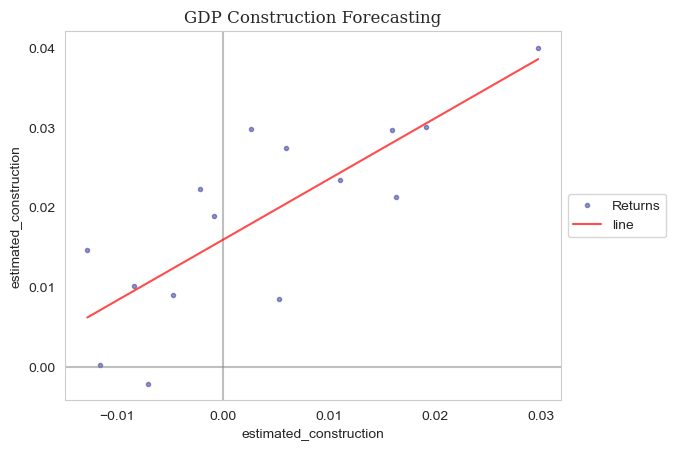

In [68]:
import seaborn as sns
beta, alpha = np.polyfit(x = y_test , y = y_pred ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(y = y_pred, x = y_test, label = 'Returns', marker = '.', color = 'navy', alpha = 0.4)
sns.lineplot(x = y_test, y = alpha + y_test * beta, color = 'red', label = 'line', alpha = 0.7)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('GDP Construction Forecasting', fontfamily = 'Serif')
plt.grid(False)
plt.show()

Text(0.5, 1.0, 'GDP Construction Forecasting')

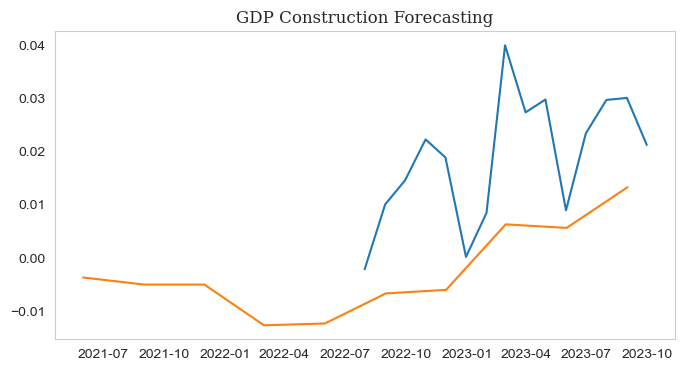

In [69]:
plt.figure(figsize = (8, 4))
plt.plot(pd.Series(y_pred, index = X_test.index))
plt.plot(gdp_c['construction_rate'][-10:].dropna() / 3)
plt.grid(False)
plt.title('GDP Construction Forecasting', fontfamily = 'Serif')

In [38]:
import shap

explainer_randomforest_reg = shap.TreeExplainer(model)

shap_values_train = explainer_randomforest_reg(X_train)
shap_values_test = explainer_randomforest_reg(X_test)
shap_values_all = explainer_randomforest_reg(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


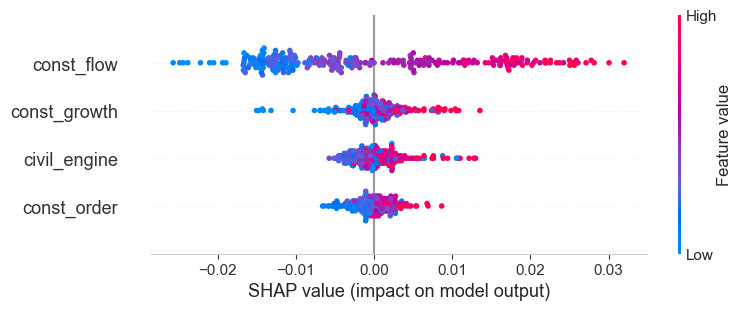

In [39]:
plt.grid(False)
shap.plots.beeswarm(shap_values_train, max_display = len(shap_values_train.feature_names))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


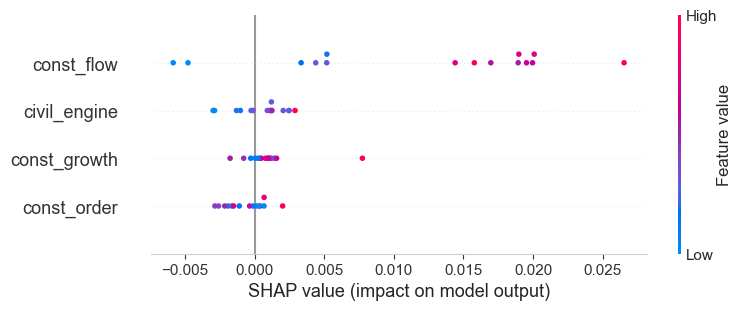

In [40]:
plt.grid(False)
shap.plots.beeswarm(shap_values_test, max_display = len(shap_values_train.feature_names))

#### 설비투자

In [42]:
equip = pd.read_excel('../../Data/Investment/설비투자.xlsx', index_col = 0) * 0.01
equip.index = pd.date_range(start = '2000-01-01', end = '2023-10-01', freq='M')
equip

,설비투자,기업대출금리,제조업생산지수,전산업생산지수,제조업출하지수,제조업재고지수,제조업가동률지수,기계수주액 증가율,서비스업생산지수,도소매업지수
2000-01-31,0.544,0.0822,0.44787,0.525,0.48996,0.38215,1.08883,0.065,0.550,0.672
2000-02-29,0.615,0.0824,0.44714,0.525,0.49395,0.38614,1.08079,0.094,0.550,0.669
2000-03-31,0.479,0.0844,0.45124,0.536,0.49395,0.39411,1.09169,0.252,0.556,0.671
2000-04-30,0.441,0.0820,0.44734,0.535,0.49057,0.38497,1.07281,0.148,0.550,0.686
2000-05-31,0.387,0.0824,0.46448,0.549,0.50514,0.38876,1.12181,0.038,0.562,0.684
...,...,...,...,...,...,...,...,...,...,...
2023-05-31,-0.049,0.0520,1.06400,1.106,1.01500,1.25000,1.02400,-0.113,1.142,1.062
2023-06-30,-0.025,0.0532,1.04700,1.106,1.04500,1.17400,1.00800,0.015,1.149,1.069
2023-07-31,-0.112,0.0525,1.02400,1.097,0.96100,1.19200,0.98400,0.017,1.153,1.056
2023-08-31,-0.146,0.0521,1.07900,1.119,0.99500,1.23700,1.03000,-0.240,1.157,1.056


In [43]:
gdp_e = pd.read_excel('../../Data/Investment/GDP 설비투자.xlsx', index_col = 0) * 0.01
gdp_e.index = pd.date_range(start = '2000-01-01', end = '2023-11-01', freq = 'Q').strftime('%Y-%m')
gdp_e.index = pd.to_datetime(gdp_e.index)

In [44]:
gdp_e

,GDP_ind_invest,ind_invest_rate
2000-03-01,0.217732,0.632
2000-06-01,0.217670,0.449
2000-09-01,0.224260,0.334
2000-12-01,0.206189,0.091
2001-03-01,0.208404,-0.033
...,...,...
2022-09-01,0.465248,0.044
2022-12-01,0.476578,0.065
2023-03-01,0.452881,0.059
2023-06-01,0.455366,0.047


In [45]:
estimated = pd.Series(
    dentonm(equip['설비투자'].cumsum(), gdp_e['ind_invest_rate'].cumsum(), freq = "qm") * 3,
    index = equip.index,
    name = 'estimated_equipment'
)

In [50]:
equipment_matrix = pd.concat(
    [
        equip,
        estimated.diff()
    ],
    axis = 1
)

In [52]:
equipment_matrix.columns = ['facil_inv','comp_yield','manuf_inv','prod_idx','manuf_ship_idx','inven_idx','util_idx','machine_order','service_idx','retail_idx','estimated_facility']

In [53]:
equipment_matrix.dropna(inplace = True)

In [54]:
# equipment_matrix.to_csv("../../Cleaned_Data/facility.csv")

#### Primary Modeling

In [70]:
X = equipment_matrix.iloc[:,:-1]
y = equipment_matrix['estimated_facility']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False)

model = RandomForestRegressor(n_estimators = 1000, 
                              random_state = 42,
                              criterion = 'squared_error',
                              max_depth = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0003782169865101546


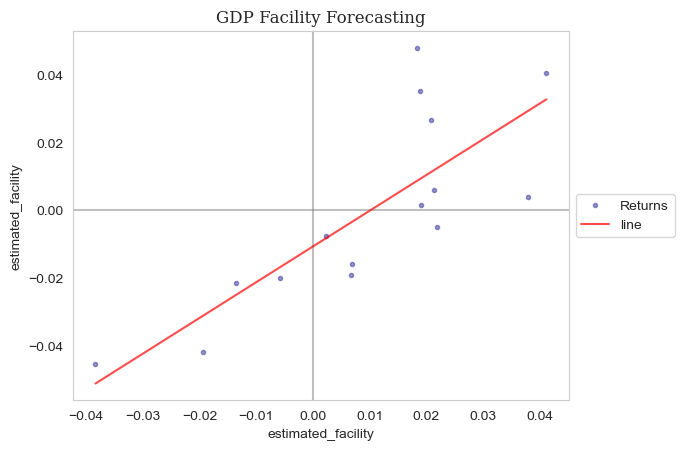

In [62]:
beta, alpha = np.polyfit(x = y_test , y = y_pred ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(y = y_pred, x = y_test, label = 'Returns', marker = '.', color = 'navy', alpha = 0.4)
sns.lineplot(x = y_test, y = alpha + y_test * beta, color = 'red', label = 'line', alpha = 0.7)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('GDP Facility Forecasting', fontfamily = 'Serif')
plt.grid(False)
plt.show()

Text(0.5, 1.0, 'GDP Fasility Investment Forecasting')

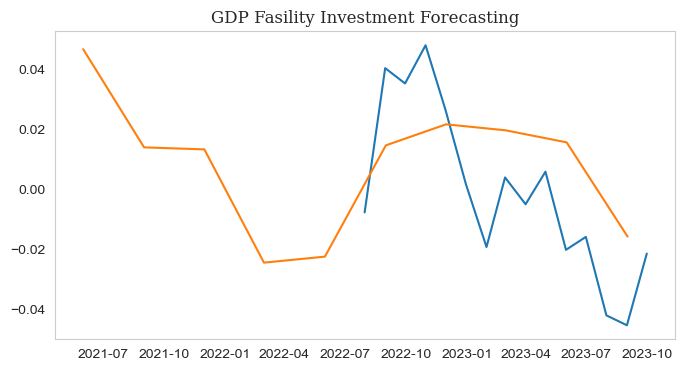

In [72]:
plt.figure(figsize = (8,4))
plt.plot(pd.Series(y_pred, index = X_test.index))
plt.plot(gdp_e['ind_invest_rate'][-10:].dropna()/3)
plt.grid(False)
plt.title('GDP Fasility Investment Forecasting', fontfamily = 'Serif')